# 3. Top-N Simulations from Actual Experimental Data

This notebook loads an existing beer ('Beer1pos') data, runs it through the simulator and compares the simulated results to the original input data. The results here correspond to Section 3.2 in the paper.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
from loguru import logger

In [3]:
import pymzml
import numpy as np
import pylab as plt
import matplotlib.patches as mpatches

In [4]:
import os
import sys
sys.path.append('../..')

In [5]:
from vimms.Common import download_file, extract_zip_file, set_log_level_debug, set_log_level_warning, \
    save_obj, load_obj, POSITIVE
from vimms.Roi import RoiParams
from vimms.Chemicals import ChemicalMixtureFromMZML
from vimms.ChemicalSamplers import MzMLScanTimeSampler

In [6]:
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController
from vimms.Environment import Environment

### 1. Extract chemicals from beer sample

Pre-requisite: make sure that the necessary input mzML file has been downloaded by running the **01. Download Data.ipynb** notebook.

Extract chemicals from the previously downloaded beer mzML files using `ChemicalMixtureFromMZML` class. The results are a list of `UnknownChemical` objects for each input mzML file. Once created, we can persist the list of `UnknownChemicals` to the file system by calling the `save_obj` method from ViMMS.

Note that the `min_intensity` threshold (1.75E5) is set very high here so the notebook completes quickly. However this means you'd only extract large regions-of-interests (ROIs) from the data, and smaller ones are omitted. For a more accurate simulation, you should lower this threshold value to e.g. 1000.

In [7]:
min_ms1_intensity = 1.75E5

In [8]:
param_dict = {
    'mz_tol': 10,
    'mz_units': 'ppm',
    'min_length': 1,
    'min_intensity': 0,
    'start_rt': 0,
    'stop_rt': 1440,
    'min_roi_intensity_for_fragmentation': min_ms1_intensity
}

In [9]:
base_dir = os.path.abspath('example_data')

In [10]:
mzml_file = os.path.join(base_dir, 'Beer_multibeers_1_T10_POS.mzML')
mzml_file

'/Users/joewandy/Work/git/vimms/examples/01. vimms (Wandy et al 2019)/example_data/Beer_multibeers_1_T10_POS.mzML'

In [11]:
rp = RoiParams(**param_dict)
cm = ChemicalMixtureFromMZML(mzml_file, roi_params=rp)
dataset = cm.sample(None, 2)

2022-02-25 14:35:11.973 | DEBUG    | vimms.Chemicals:_extract_rois:458 - Extracted 10062 good ROIs from /Users/joewandy/Work/git/vimms/examples/01. vimms (Wandy et al 2019)/example_data/Beer_multibeers_1_T10_POS.mzML


In [12]:
len(dataset)

10062

Create a scan-time sampler to get a more accurate estimate of the average duration a scan would take during simulation, based on existing experimental data.

In [13]:
sd = MzMLScanTimeSampler(mzml_file)

2022-02-25 14:35:13.359 | DEBUG    | vimms.ChemicalSamplers:_extract_timing:716 - Extracting timing dictionary from seed file
2022-02-25 14:35:16.862 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 9423 scans
2022-02-25 14:35:16.911 | DEBUG    | vimms.ChemicalSamplers:_extract_mean_time:754 - 1: 0.273100
2022-02-25 14:35:16.911 | DEBUG    | vimms.ChemicalSamplers:_extract_mean_time:754 - 2: 0.131625


### 2. Run Simulated Top-N Controller

Perform a simulated injection of the beer data using the Top-N controller.

In [14]:
out_dir = os.path.join(os.getcwd(), 'results', 'mzml_compare')

In [15]:
rt_range = [(0, 1440)]
min_rt = rt_range[0][0]
max_rt = rt_range[0][1]

In [16]:
isolation_window = 1   # the (full) isolation width in Dalton around a selected precursor m/z
ionisation_mode = POSITIVE
N = 10
rt_tol = 15
mz_tol = 10

In [17]:
set_log_level_warning()

1

In [18]:
mass_spec = IndependentMassSpectrometer(POSITIVE, dataset, scan_duration=sd)
controller = TopNController(POSITIVE, N, isolation_window, mz_tol, rt_tol, min_ms1_intensity)    
env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)
env.run()

label = 'beer1pos'
mzml_out = 'simulated_%s.mzML' % label
env.write_mzML(out_dir, mzml_out)

  0%|          | 0/1440 [00:00<?, ?it/s]

Simulated mzML have been created, and you can use ToppView from OpenMS or other mzML viewer to inspect the results.

### Compare simulated results to actual input

#### Load simulated and real data.

In [19]:
def count_stuff(input_file, min_rt, max_rt):
    run = pymzml.run.Reader(input_file, MS1_Precision=5e-6,
                            extraAccessions=[('MS:1000016', ['value', 'unitName'])],
                            obo_version='4.0.1')
    mzs = []
    rts = []
    intensities = []
    count_ms1_scans = 0
    count_ms2_scans = 0
    cumsum_ms1_scans = []
    cumsum_ms2_scans = []
    count_selected_precursors = 0
    for spectrum in run:
        ms_level = spectrum['ms level']
        current_scan_rt, units = spectrum.scan_time
        if units == 'minute':
            current_scan_rt *= 60.0
        if min_rt < current_scan_rt < max_rt:
            if ms_level == 1:
                count_ms1_scans += 1
                cumsum_ms1_scans.append((current_scan_rt, count_ms1_scans,))
            elif ms_level == 2:
                try:
                    selected_precursors = spectrum.selected_precursors
                    count_selected_precursors += len(selected_precursors)
                    mz = selected_precursors[0]['mz']
                    intensity = selected_precursors[0]['i']

                    count_ms2_scans += 1
                    mzs.append(mz)
                    rts.append(current_scan_rt)
                    intensities.append(intensity)
                    cumsum_ms2_scans.append((current_scan_rt, count_ms2_scans,))
                except KeyError:
                    # logger.debug(selected_precursors)
                    pass

    logger.debug('Number of ms1 scans =', count_ms1_scans)
    logger.debug('Number of ms2 scans =', count_ms2_scans)
    logger.debug('Total scans =', count_ms1_scans + count_ms2_scans)
    logger.debug('Number of selected precursors =', count_selected_precursors)
    return np.array(mzs), np.array(rts), np.array(intensities), np.array(cumsum_ms1_scans), np.array(cumsum_ms2_scans)

In [20]:
simulated_input_file = os.path.join(out_dir, mzml_out)
simulated_mzs, simulated_rts, simulated_intensities, simulated_cumsum_ms1, simulated_cumsum_ms2 = count_stuff(
    simulated_input_file, min_rt, max_rt)

In [21]:
real_input_file = mzml_file
real_mzs, real_rts, real_intensities, real_cumsum_ms1, real_cumsum_ms2 = count_stuff(
    real_input_file, min_rt, max_rt)

#### Plot number of scans

In [22]:
def plot_num_scans(real_cumsum_ms1, real_cumsum_ms2, simulated_cumsum_ms1, simulated_cumsum_ms2, out_file=None):
    plt.plot(real_cumsum_ms1[:, 0], real_cumsum_ms1[:, 1], 'r')
    plt.plot(real_cumsum_ms2[:, 0], real_cumsum_ms2[:, 1], 'b')
    plt.plot(simulated_cumsum_ms1[:, 0], simulated_cumsum_ms1[:, 1], 'r--')
    plt.plot(simulated_cumsum_ms2[:, 0], simulated_cumsum_ms2[:, 1], 'b--')

    plt.legend(['Actual MS1', 'Actual MS2', 'Simulated MS1', 'Simulated MS2'])
    plt.xlabel('Retention Time (s)')
    plt.ylabel('Cumulative sum')
    plt.title('Cumulative number of MS1 and MS2 scans', fontsize=18)
    plt.tight_layout()

    if out_file is not None:
        plt.savefig(out_file, dpi=300)

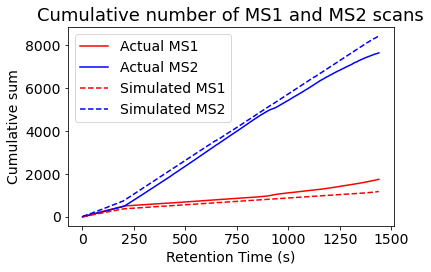

In [23]:
plt.rcParams.update({'font.size': 14})
out_file = os.path.join(out_dir, 'topN_num_scans.png')
plot_num_scans(real_cumsum_ms1, real_cumsum_ms2, simulated_cumsum_ms1, simulated_cumsum_ms2, out_file)

### Check the number of precursors that could be matched at different m/z and RT tolerances

In [24]:
def match_peaklist(mz_list_1, rt_list_1, intensity_list_1, mz_list_2, rt_list_2, intensity_list_2, mz_tol, rt_tol):
    if mz_tol is not None:  # create mz range for matching in ppm
        min_mzs = np.array([mz * (1 - mz_tol / 1e6) for mz in mz_list_2])
        max_mzs = np.array([mz * (1 + mz_tol / 1e6) for mz in mz_list_2])

    else:  # create mz ranges by rounding to 2dp
        min_mzs = np.around(mz_list_2, decimals=2)
        max_mzs = np.around(mz_list_2, decimals=2)
        mz_list_1 = np.around(mz_list_1, decimals=2)

    # create rt ranges for matching
    min_rts = np.array([rt - rt_tol for rt in rt_list_2])
    max_rts = np.array([rt + rt_tol for rt in rt_list_2])

    matches = {}
    for i in range(len(mz_list_1)):  # loop over query and find a match
        query = (mz_list_1[i], rt_list_1[i], intensity_list_1[i],)
        match = find_match(query, min_rts, max_rts, min_mzs, max_mzs, mz_list_2, rt_list_2, intensity_list_2)
        matches[query] = match
    return matches


def find_match(query, min_rts, max_rts, min_mzs, max_mzs, mz_list, rt_list, intensity_list):
    # check ranges
    query_mz, query_rt, query_intensity = query
    min_rt_check = min_rts <= query_rt
    max_rt_check = query_rt <= max_rts
    min_mz_check = min_mzs <= query_mz
    max_mz_check = query_mz <= max_mzs
    idx = np.nonzero(min_rt_check & max_rt_check & min_mz_check & max_mz_check)[0]

    # get mz, rt and intensity of matching indices
    matches_mz = mz_list[idx]
    matches_rt = rt_list[idx]
    matches_intensity = intensity_list[idx]

    if len(idx) == 0:  # no match
        return None

    elif len(idx) == 1:  # single match
        return (matches_mz[0], matches_rt[0], matches_intensity[0],)

    else:  # multiple matches, take the closest in rt
        diffs = [np.abs(rt - query_rt) for rt in matches_rt]
        idx = np.argmin(diffs)
        return (matches_mz[idx], matches_rt[idx], matches_intensity[idx],)


def check_found_matches(matches, left_label, right_label, N=20):
    found = [key for key in matches if matches[key] is not None]
    logger.debug('Found %d/%d (%f)' % (len(found), len(matches), len(found) / len(matches)))

    logger.debug('%s\t\t\t\t\t\t%s' % (left_label, right_label))
    for key, value in list(matches.items())[0:N]:
        if value is not None:
            logger.debug('mz %.2f rt %.4f intensity %.4f\tmz %.2f rt %.4f intensity %.4f' % (
                key[0], key[1], key[2], value[0], value[1], value[2]))

In [25]:
mz_tol = None # in ppm. if None, then 2 decimal places is used for matching the m/z
rt_tol = 5 # seconds
matches = match_peaklist(real_mzs, real_rts, real_intensities, simulated_mzs, simulated_rts, simulated_intensities, mz_tol, rt_tol)
check_found_matches(matches, 'Real', 'Simulated')

In [26]:
mz_tol = None
rt_tol = 10
matches = match_peaklist(real_mzs, real_rts, real_intensities, simulated_mzs, simulated_rts, simulated_intensities, mz_tol, rt_tol)
check_found_matches(matches, 'Real', 'Simulated')

In [27]:
mz_tol = None
rt_tol = 15
matches = match_peaklist(real_mzs, real_rts, real_intensities, simulated_mzs, simulated_rts, simulated_intensities, mz_tol, rt_tol)
check_found_matches(matches, 'Real', 'Simulated')

### Plot the matches

In [28]:
unmatched_intensities = []
matched_intensities = []
for key, value in list(matches.items()):
    intensity = key[2]
    if value is None:
        unmatched_intensities.append(intensity)
    else:
        matched_intensities.append(intensity)

In [29]:
plt.rcParams.update({'font.size': 18})   

In [30]:
def plot_matched_intensities(matched_intensities, unmatched_intensities, out_file=None):
    plt.figure()
    temp1 = plt.hist(np.log(matched_intensities), bins=np.linspace(10, 20, 50), color='blue')
    temp2 = plt.hist(np.log(unmatched_intensities), bins=np.linspace(10, 20, 50), color='red')
    plt.title('Matched precursor intensities')

    blue_patch = mpatches.Patch(color='blue', label='Matched')
    red_patch = mpatches.Patch(color='red', label='Unmatched')
    plt.legend(handles=[blue_patch, red_patch])
    plt.xlabel('log(intensity)')
    plt.ylabel('Precursor count')
    plt.tight_layout()

    if out_file is not None:
        plt.savefig(out_file, dpi=300)

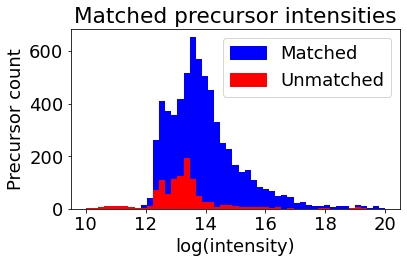

In [31]:
out_file = os.path.join(out_dir, 'topN_matched_intensities.png')
plot_matched_intensities(matched_intensities, unmatched_intensities, out_file)

In [32]:
def plot_matched_precursors(matches, min_mz, max_mz, min_rt, max_rt, out_file=None):
    plt.figure(figsize=(12, 6))
    plt.rcParams.update({'font.size': 24})
    for key in matches:
        mz, rt, intensity = key
        if min_mz < mz < max_mz and min_rt < rt < max_rt:
            if matches[key] is not None:
                plt.plot([rt], [mz], marker='.', markersize=5, color='blue', alpha=0.1)
            else:
                plt.plot([rt], [mz], marker='.', markersize=5, color='red', alpha=0.1)

    blue_patch = mpatches.Patch(color='blue', label='Matched')
    red_patch = mpatches.Patch(color='red', label='Unmatched')
    plt.legend(handles=[blue_patch, red_patch])
    plt.title('Matched fragmentation events', fontsize=30)
    plt.xlabel('Retention Time (s)')
    plt.ylabel('m/z')
    plt.tight_layout()
    if out_file is not None:
        plt.savefig(out_file, dpi=300)

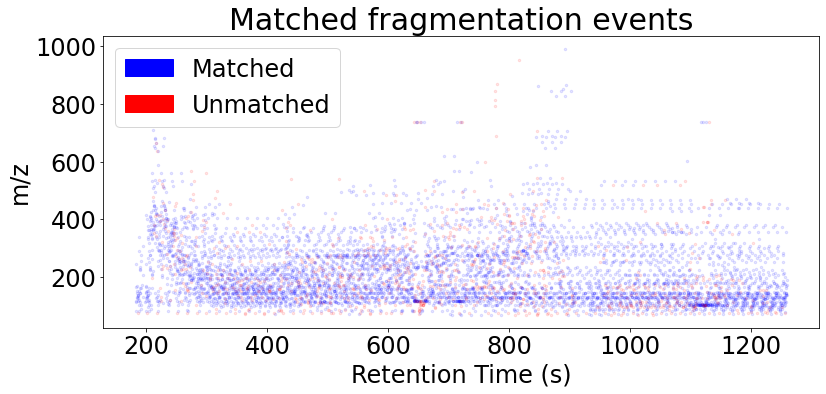

In [33]:
out_file = os.path.join(out_dir, 'topN_matched_precursors.png')
plot_matched_precursors(matches, 50, 1000, 180, 1260, out_file)